<a href="https://colab.research.google.com/github/HarshTiVV/Main-Project/blob/main/Copy_of_NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re


data = pd.read_csv("/content/reviews_data.csv")


simple_stopwords = set([
    "i", "me", "my", "we", "our", "you", "your", "he", "she", "it", "they",
    "what", "which", "who", "this", "that", "these", "those", "am", "is", "are",
    "was", "were", "be", "been", "have", "has", "do", "does", "did", "doing",
    "a", "an", "the", "and", "but", "if", "or", "because", "as", "until",
    "of", "at", "by", "for", "with", "about", "against", "between", "to", "from",
    "up", "down", "in", "out", "on", "over", "again", "further", "then", "here",
    "there", "when", "where", "why", "how", "all", "any", "both", "each",
    "few", "more", "most", "other", "some", "such", "no", "nor", "not", "own",
    "so", "than", "too", "very", "can", "will", "just", "should", "now"
])


def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    words = text.split()
    filtered_words = [word for word in words if word not in simple_stopwords]
    return " ".join(filtered_words)


data['Cleaned_Review'] = data['Review'].apply(preprocess_text)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Cleaned_Review'])
vocab_size = len(tokenizer.word_index) + 1


sequences = tokenizer.texts_to_sequences(data['Cleaned_Review'])
padded_sequences = pad_sequences(sequences, padding='post', maxlen=100)


from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(padded_sequences, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Attention


input_layer = Input(shape=(100,), name="input_layer")
embedding_layer = Embedding(input_dim=vocab_size, output_dim=64, name="embedding")(input_layer)
lstm_layer = LSTM(64, return_sequences=True, name="lstm")(embedding_layer)
attention_layer = Attention(name="attention")([lstm_layer, lstm_layer])
output_layer = Dense(vocab_size, activation='softmax', name="output")(attention_layer)


rnn_attention_model = Model(inputs=input_layer, outputs=output_layer)
rnn_attention_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn_attention_model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 64)        │        366,912 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 100, 64)        │         33,024 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 100, 64)        │              0 │ lstm[0][0], lstm[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 100, 5733)      │        372,645 │ attention[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 772,581 (2.95 MB)

 Trainable params: 772,581 (2.95 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dense, Dropout, Layer
from tensorflow.keras import Sequential

class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):

        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)  # Apply dropout
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)  # Apply dropout
        return self.layernorm2(out1 + ffn_output)

embed_dim = 64
num_heads = 2
ff_dim = 128


input_layer = Input(shape=(100,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embed_dim)(input_layer)
transformer_block = TransformerBlock(embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim)(embedding_layer, training=True)
output_layer = Dense(vocab_size, activation='softmax')(transformer_block)

transformer_model = Model(inputs=input_layer, outputs=output_layer)
transformer_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
transformer_model.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_7 (Embedding)              │ (None, 100, 64)             │         366,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_4                  │ (None, 100, 64)             │          50,048 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 100, 5733)           │         372,645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 789,605 (3.01 MB)

 Trainable params: 789,605 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
input_layer = Input(shape=(100,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=64)(input_layer)


lstm_layer = LSTM(64, return_sequences=True)(embedding_layer)

transformer_layer = TransformerBlock(embed_dim=64, num_heads=2, ff_dim=128)(lstm_layer)


attention_layer = Attention()([transformer_layer, transformer_layer])
output_layer = Dense(vocab_size, activation='softmax')(attention_layer)

hybrid_model = Model(inputs=input_layer, outputs=output_layer)
hybrid_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hybrid_model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_8 (Embedding)   │ (None, 100, 64)        │        366,912 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ (None, 100, 64)        │         33,024 │ embedding_8[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_5       │ (None, 100, 64)        │         50,048 │ lstm_4[0][0]           │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_3 (Attention)   │ (None, 100, 64)        │              0 │ transformer_block_5[0… │
│                           │                        │                │ transformer_block_5[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 100, 5733)      │        372,645 │ attention_3[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 822,629 (3.14 MB)

 Trainable params: 822,629 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

epochs = 10
batch_size = 32

rnn_attention_model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, X_test))
transformer_model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, X_test))
hybrid_model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, X_test))


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 831ms/step - accuracy: 0.4531 - loss: 8.4037 - val_accuracy: 0.5709 - val_loss: 6.9378
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 778ms/step - accuracy: 0.5638 - loss: 6.4442 - val_accuracy: 0.5709 - val_loss: 5.1423
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 822ms/step - accuracy: 0.5250 - loss: 4.9893 - val_accuracy: 0.5709 - val_loss: 4.0504
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 771ms/step - accuracy: 0.5483 - loss: 4.0670 - val_accuracy: 0.5709 - val_loss: 3.8579
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 876ms/step - accuracy: 0.5337 - loss: 4.0796 - val_accuracy: 0.5709 - val_loss: 3.8522
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 794ms/step - accuracy: 0.5269 - loss: 4.1002 - val_accuracy: 0.5709 - val_loss: 3.6837
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 784ms/step - accuracy: 0.5528 - loss: 3.6947 - val_accuracy: 0.5709 - val_loss: 3.5321
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 923ms/step - accuracy: 0.5521 - loss: 3.5733 - val_accu

In [ ]:
import numpy as np

def generate_summary(model, input_seq):
    prediction = model.predict(np.array([input_seq]))
    predicted_seq = np.argmax(prediction, axis=-1)
    return " ".join([tokenizer.index_word.get(idx, '') for idx in predicted_seq[0] if idx > 0])

example_index = 0
example_input = X_test[example_index]

original_review = data['Cleaned_Review'].iloc[example_index]
print("Original Review:", original_review)
print("Generated Summary:", generate_summary(hybrid_model, example_input))



Original Review: amber ladonna starbucks southwest parkway always warm welcoming always smile their voice greet drivethru their customer service always spoton always get order right smile would actually give them stars available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
Generated Summary: go go go ave sugar sugar drink starbucks least times week employees use friendly last work employees employees rude rude going their into smiling saying thank go put top top already already their two without thank thank store busy slow customer service service huge gift gift into given service also served hard say say several times employees total made employees really know know ask them make one get dirty look their


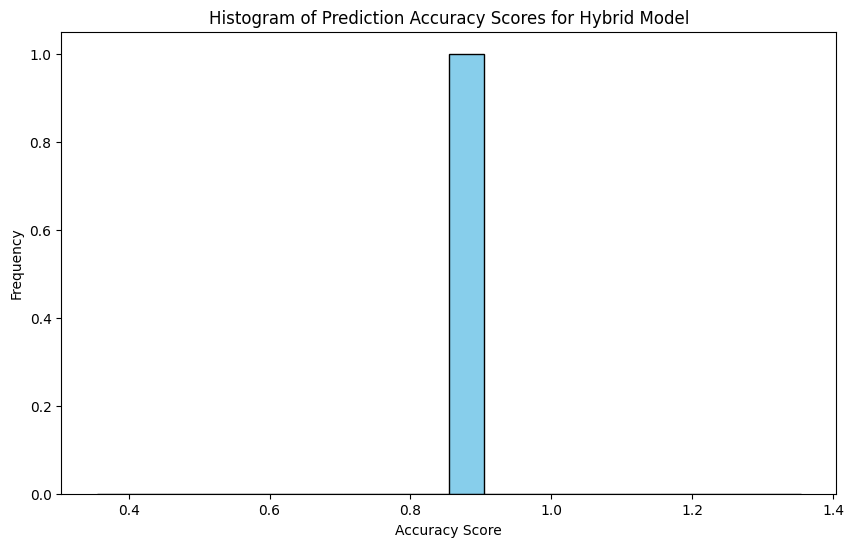

In [ ]:
import matplotlib.pyplot as plt


loss, accuracy = hybrid_model.evaluate(X_test, X_test, verbose=0)

plt.figure(figsize=(10, 6))
plt.hist(accuracy, bins=20, color='skyblue', edgecolor='black')
plt.title("Histogram of Prediction Accuracy Scores for Hybrid Model")
plt.xlabel("Accuracy Score")
plt.ylabel("Frequency")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


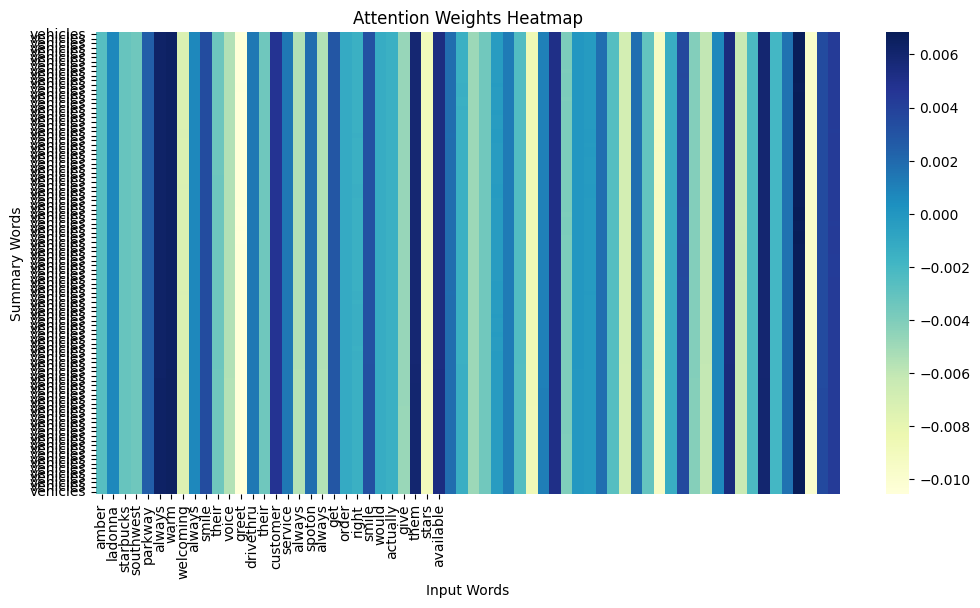

In [ ]:
import seaborn as sns
import numpy as np


def generate_summary_with_attention(model, input_seq):

    attention_layer_output = model.get_layer('attention').output
    intermediate_model = Model(inputs=model.input, outputs=[model.output, attention_layer_output])

    prediction, attention_weights = intermediate_model.predict(np.array([input_seq]))
    predicted_seq = np.argmax(prediction, axis=-1)

    summary_text = " ".join([tokenizer.index_word.get(idx, '') for idx in predicted_seq[0] if idx > 0])
    return summary_text, attention_weights


example_index = 0
example_input = X_test[example_index]
original_review = data['Cleaned_Review'].iloc[example_index]


summary, attention_weights = generate_summary_with_attention(rnn_attention_model, example_input)


plt.figure(figsize=(12, 6))
sns.heatmap(attention_weights[0], cmap="YlGnBu", xticklabels=original_review.split(), yticklabels=summary.split())
plt.title("Attention Weights Heatmap")
plt.xlabel("Input Words")
plt.ylabel("Summary Words")
plt.show()
